In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

sns.set()
sns.set_style("white")

%matplotlib inline

In [2]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

In [3]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05,
              'alpha': 1}

In [6]:
def dual_process_model_generalized(state_init, params, niter, durations):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    alpha = params['alpha']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    uS = u.copy()
    vS = v.copy()
    yS = y.copy()
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
        
    sig_lst = []
    u_sim = []
    v_sim = []
    y_sim = []
    I_lst = []
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    durs = np.cumsum(np.divide(durations,dt))
    durs = durs.astype(int)
    
    for i in range(niter): 
        
        if any(i == durs):
            sig = 1.0
            #print('flash')
        else:
            sig = 0.0
        
        # I update here:
        I += (sig * K * (yS - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        yS += (-yS + uS - vS + np.random.randn(ntrials) * sigma) / 100 * dt

        v_sim.append(vS.copy())
        u_sim.append(uS.copy())
        y_sim.append(yS.copy())
        I_lst.append(I.copy())
        #sig_lst.append(np.tile(sig,[ntrials,1])) 
        sig_lst.append(sig) 
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt

        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / 100 * dt
        
        IP = I.copy() + alpha*(yP.copy() - yS.copy())

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        #production_lst.append(np.tile(sigP,[ntrials,1]))
        production_lst.append(sigP)
        
    return u_sim, v_sim, y_sim, I_lst, sig_lst, u_p, v_p, y_p, I_p, production_lst

In [7]:
def simulate_synchronization2(ntrials=1, durations=[600, 600, 600, 600, 1000, 600, 600], sigma=0, K=3.0, initI=0.7, alpha=0.5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    PARAMS_DICT['alpha'] = alpha
    
    nbin = int(sum(np.divide(durations,PARAMS_DICT['dt'])))
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.87, 
                  np.ones(ntrials) * 0.25,
                  np.ones(ntrials) * 0.5,
                  0.0]

    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = dual_process_model_generalized(state_init, PARAMS_DICT, nbin, durations)


    return usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst 

def asynchronies(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst),dt)
    flash_times = np.multiply(np.nonzero(sig_lst),dt)
    A = np.zeros((np.size(flash_times[0,:]),np.size(press_times[0,:])))
    asynch = np.zeros((1,np.size(press_times[0,:])))
    for i in range(np.size(flash_times[0,:])):
        for j in range(np.size(press_times[0,:])):
            A[i,j] = np.subtract(press_times[0,j],flash_times[0,i])
    for j in range(np.size(press_times[0,:])):
        ind = np.unravel_index(np.argmin(abs(A[:,j]), axis=None),A[:,j].shape)
        asynch[0,j] = A[ind,j]
        
    #if np.size(flash_times[0,:]) >= np.size(press_times[0,:]):
    #    asynch = np.subtract(press_times[0,:],flash_times[0,:np.size(press_times[0,:])])
    #else:
    #    asynch = np.subtract(press_times[0,:np.size(flash_times[0,:])],flash_times[0,:])
        
#def asynchronies_multi(sig_lst)
        
#    for i in range(len(flash_times)):
#        asynch[i] = press_times[i] - flash_times[i]
        
    return asynch, press_times, flash_times

def isi_ipi(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst),dt)
    flash_times = np.multiply(np.nonzero(sig_lst),dt)
    
    isi = np.diff(flash_times)
    ipi = np.diff(press_times)
    
    return isi, ipi, press_times, flash_times

Optimation of K and alpha

In [8]:
durlst = 800*np.ones(40)
nexp = 50
nK = 5
nalpha = 11
Klst = np.linspace(2,4, nK)
alpha_lst = np.linspace(0.0, 0.3, nalpha)
startInd = 5
endInd = 25
mPeriodError = np.zeros((nK,nalpha))
mAsynch = np.zeros((nK,nalpha))

uplst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
vplst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
yplst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
Iplst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
Plst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))

uslst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
vslst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
yslst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
Islst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
Slst = np.zeros((int(np.sum(durlst)/PARAMS_DICT['dt']),nexp,nK,nalpha))
for i in range(nK):
    print('Working on i = ', i)
    for j in range(nalpha):
        # Set K and alpha
        K = Klst[i]
        alpha = alpha_lst[j]
        
        sPeriodErrs = np.zeros(nexp)
        sAsynch = np.zeros(nexp)
        for k in range(nexp):
            # Perform experiment
            usim, vsim, ysim, Ilst, siglst2, u_p, v_p, y_p, I_p, production_lst2 = simulate_synchronization2(ntrials=1, 
                                                                               durations=durlst, 
                                                                               sigma=0.01, K=K, initI=0.771, alpha = alpha)

            uplst[:,k,i,j] = u_p
            vplst[:,k,i,j] = v_p
            yplst[:,k,i,j] = y_p
            Iplst[:,k,i,j] = I_p
            Plst[:,k,i,j] = production_lst2
            
            uslst[:,k,i,j] = usim
            vslst[:,k,i,j] = vsim
            yslst[:,k,i,j] = ysim
            Islst[:,k,i,j] = Ilst
            Slst[:,k,i,j] = siglst2
            
            # plot
            #if j == 4:
            #plt.figure(figsize=(5, 5))
            #plt.plot(ysim)
            #plt.plot(y_p)
        
            # Find isi, etc.
            isi, ipi, press_times, flash_times = isi_ipi(siglst2,production_lst2,PARAMS_DICT['dt'])
            asynch, press_times, flash_times = asynchronies(siglst2,production_lst2,PARAMS_DICT['dt'])
            
            if np.size(isi[0,:]) >= np.size(ipi[0,:]):
                sPeriodErrs[k] = np.sum((isi[0,startInd:np.size(ipi[0,:])]-ipi[0,startInd:])**2)
            else:
                sPeriodErrs[k] = np.sum((isi[0,startInd:]-ipi[0,startInd:np.size(isi[0,:])])**2)
                
            sAsynch[k] = np.sum(asynch**2)
            
   
        mPeriodError[i,j] = np.mean(sPeriodErrs)
        mAsynch[i,j] = np.mean(sAsynch)

Working on i =  0
Working on i =  1
Working on i =  2
Working on i =  3
Working on i =  4


In [9]:
x = {}
x['Klst'] = Klst
x['alpha_lst'] = alpha_lst

x['uplst'] = uplst
x['vplst'] = vplst
x['yplst'] = yplst
x['Iplst'] = Iplst
x['Plst'] = Plst

x['uslst'] = uslst
x['vslst'] = vslst
x['yslst'] = yslst
x['Islst'] = Islst
x['Slst'] = Slst

x['mPeriodError'] = mPeriodError
x['mAsynch'] = mAsynch
#scipy.io.savemat('Synchronization_K_alpha.mat',x)

2366504.0
86312.0
2746334.0
489320.0


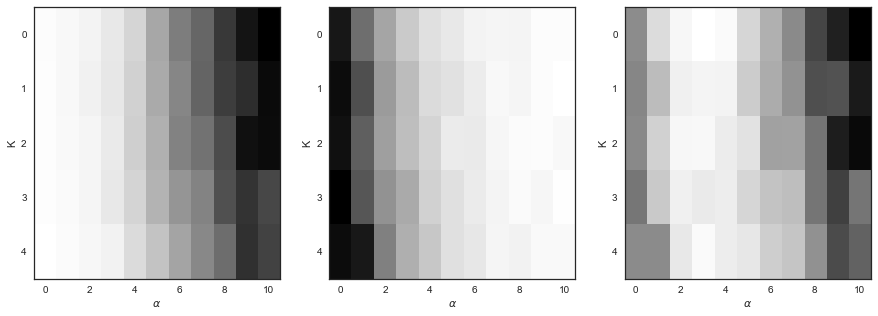

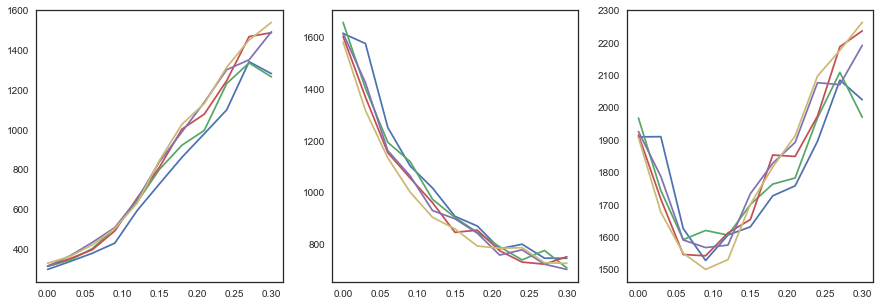

In [10]:
print(np.amax(mPeriodError))
print(np.amin(mPeriodError))
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.flipud((mPeriodError))**(1/2), aspect='auto')
plt.ylabel('K')
plt.xlabel(r'$\alpha$')


print(np.amax(mAsynch))
print(np.amin(mAsynch))
plt.subplot(1, 3, 2)
plt.imshow(np.flipud((mAsynch))**(1/2), aspect='auto')
plt.ylabel('K')
plt.xlabel(r'$\alpha$')

plt.subplot(1, 3, 3)
plt.imshow(np.flipud((mPeriodError))**(1/2) + np.flipud((mAsynch))**(1/2), aspect='auto')
plt.ylabel('K')
plt.xlabel(r'$\alpha$')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
for i in range(nK):
    plt.plot(alpha_lst,mPeriodError[i,:]**(1/2))
    
plt.subplot(1, 3, 2)
for i in range(nK):
    plt.plot(alpha_lst,mAsynch[i,:]**(1/2))
    
plt.subplot(1,3,3)
for i in range(nK):
    plt.plot(alpha_lst,mPeriodError[i,:]**(1/2) + mAsynch[i,:]**(1/2))

Matching IPI to ISI without augmented input

In [11]:
nexp = 50
uplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
vplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
yplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Iplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Plst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))

uslst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
vslst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
yslst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Islst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Slst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
asynchLst = np.zeros((120,nexp))
isiLst = np.zeros((120,nexp))
ipiLst = np.zeros((120,nexp))
durLst = np.zeros((100,nexp))
for k in range(nexp):
    print(k)
    durlst = np.concatenate((800*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20)),
                            0)
    
    durLst[:,k] = durlst
    
    # Perform experiment
    usim, vsim, ysim, Ilst, siglst2, u_p, v_p, y_p, I_p, production_lst2 = simulate_synchronization2(ntrials=1, 
                                                                       durations=durlst, 
                                                                       sigma=0.01, K=2, initI=0.771, alpha = 0.0)

    uplst[:len(u_p),k] = u_p
    vplst[:len(u_p),k] = v_p
    yplst[:len(u_p),k] = y_p
    Iplst[:len(u_p),k] = I_p
    Plst[:len(u_p),k] = production_lst2

    uslst[:len(u_p),k] = usim
    vslst[:len(u_p),k] = vsim
    yslst[:len(u_p),k] = ysim
    Islst[:len(u_p),k] = Ilst
    Slst[:len(u_p),k] = siglst2

    # plot
    #if j == 4:
    #plt.figure(figsize=(5, 5))
    #plt.plot(ysim)
    #plt.plot(y_p)

    # Find isi, etc.
    isi, ipi, press_times, flash_times = isi_ipi(siglst2,production_lst2,PARAMS_DICT['dt'])
    asynch, press_times, flash_times = asynchronies(siglst2,production_lst2,PARAMS_DICT['dt'])
    
    asynchLst[:asynch.shape[1],k] = asynch
    isiLst[:isi.shape[1],k] = isi
    ipiLst[:ipi.shape[1],k] = ipi[0,:]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [12]:
x = {}
x['durLst'] = durLst

x['uplst'] = uplst
x['vplst'] = vplst
x['yplst'] = yplst
x['Iplst'] = Iplst
x['Plst'] = Plst

x['uslst'] = uslst
x['vslst'] = vslst
x['yslst'] = yslst
x['Islst'] = Islst
x['Slst'] = Slst

x['asynchLst'] = asynchLst
x['isiLst'] = isiLst
x['ipiLst'] = ipiLst
#scipy.io.savemat('Synchronization_random_drift_alpha00.mat',x)

Matching IPI to ISI with augmented input

In [13]:
nexp = 50

uplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
vplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
yplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Iplst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Plst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))

uslst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
vslst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
yslst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Islst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
Slst = np.zeros((int(1000*20*5/PARAMS_DICT['dt']),nexp))
asynchLst = np.zeros((120,nexp))
isiLst = np.zeros((120,nexp))
ipiLst = np.zeros((120,nexp))
durLst = np.zeros((100,nexp))
for k in range(nexp):
    print(k)
    durlst = np.concatenate((800*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20),
                            np.random.randint(6,10)*100*np.ones(20)),
                            0)
    
    durLst[:,k] = durlst
    
    # Perform experiment
    usim, vsim, ysim, Ilst, siglst2, u_p, v_p, y_p, I_p, production_lst2 = simulate_synchronization2(ntrials=1, 
                                                                       durations=durlst, 
                                                                       sigma=0.01, K=2, initI=0.771, alpha = 0.1)

    uplst[:len(u_p),k] = u_p
    vplst[:len(u_p),k] = v_p
    yplst[:len(u_p),k] = y_p
    Iplst[:len(u_p),k] = I_p
    Plst[:len(u_p),k] = production_lst2

    uslst[:len(u_p),k] = usim
    vslst[:len(u_p),k] = vsim
    yslst[:len(u_p),k] = ysim
    Islst[:len(u_p),k] = Ilst
    Slst[:len(u_p),k] = siglst2

    # plot
    #if j == 4:
    #plt.figure(figsize=(5, 5))
    #plt.plot(ysim)
    #plt.plot(y_p)

    # Find isi, etc.
    isi, ipi, press_times, flash_times = isi_ipi(siglst2,production_lst2,PARAMS_DICT['dt'])
    asynch, press_times, flash_times = asynchronies(siglst2,production_lst2,PARAMS_DICT['dt'])

    asynchLst[:asynch.shape[1],k] = asynch
    isiLst[:isi.shape[1],k] = isi
    ipiLst[:ipi.shape[1],k] = ipi[0,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [16]:
x = {}
x['durLst'] = durLst

x['uplst'] = uplst
x['vplst'] = vplst
x['yplst'] = yplst
x['Iplst'] = Iplst
x['Plst'] = Plst

x['uslst'] = uslst
x['vslst'] = vslst
x['yslst'] = yslst
x['Islst'] = Islst
x['Slst'] = Slst

x['asynchLst'] = asynchLst
x['isiLst'] = isiLst
x['ipiLst'] = ipiLst
#scipy.io.savemat('Synchronization_random_drift_alpha01.mat',x)

Step change

In [17]:
nexp = 1000
PARAMS_DICT['dt'] = 10
alpha = 0.15
K = 1
sigma = 0.005
durations = np.concatenate((800*np.ones(30),1000*np.ones(30)))
#durations = [800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
uplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
vplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
yplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
Iplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
Plst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))

uslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
vslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
yslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
Islst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
Slst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp))
asynchLst = np.zeros((70,nexp))
isiLst = np.zeros((70,nexp))
ipiLst = np.zeros((70,nexp))
durLst = np.zeros((len(durations),nexp))
for k in range(nexp):
    #print(k)    
    durLst[:,k] = durations
    
    # Perform experiment
    usim, vsim, ysim, Ilst, siglst2, u_p, v_p, y_p, I_p, production_lst2 = simulate_synchronization2(ntrials=1, 
                                                                       durations=durations, 
                                                                       sigma=sigma, K=K, initI=0.771, alpha = alpha)

    uplst[:len(u_p),k] = u_p
    vplst[:len(u_p),k] = v_p
    yplst[:len(u_p),k] = y_p
    Iplst[:len(u_p),k] = I_p
    Plst[:len(u_p),k] = production_lst2

    uslst[:len(u_p),k] = usim
    vslst[:len(u_p),k] = vsim
    yslst[:len(u_p),k] = ysim
    Islst[:len(u_p),k] = Ilst
    Slst[:len(u_p),k] = siglst2

    # plot
    #if j == 4:
    #plt.figure(figsize=(5, 5))
    #plt.plot(ysim)
    #plt.plot(y_p)

    # Find isi, etc.
    isi, ipi, press_times, flash_times = isi_ipi(siglst2,production_lst2,PARAMS_DICT['dt'])
    asynch, press_times, flash_times = asynchronies(siglst2,production_lst2,PARAMS_DICT['dt'])

    asynchLst[:asynch.shape[1],k] = asynch
    isiLst[:isi.shape[1],k] = isi
    ipiLst[:ipi.shape[1],k] = ipi[0,:]
    
PARAMS_DICT['dt'] = 10

In [18]:
x = {}
x['durLst'] = durLst
x['alpha'] = alpha
x['K'] = K
x['sigma'] = sigma

x['uplst'] = uplst
x['vplst'] = vplst
x['yplst'] = yplst
x['Iplst'] = Iplst
x['Plst'] = Plst

x['uslst'] = uslst
x['vslst'] = vslst
x['yslst'] = yslst
x['Islst'] = Islst
x['Slst'] = Slst

x['asynchLst'] = asynchLst
x['isiLst'] = isiLst
x['ipiLst'] = ipiLst
scipy.io.savemat('Synch_StepChange.mat',x)

Phase shift

In [19]:
nexp = 500
K = 2
alphas = [0.05, 0.1, 0.15, 0.20]
sigma = 0.005
phasePerturbLst = [100]
durations = np.concatenate((500*np.ones(50),(500+phasePerturbLst[-1])*np.ones(1),500*np.ones(29)))
uplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
vplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
yplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Iplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Plst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))

uslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
vslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
yslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Islst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Slst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))

asynchLst = np.zeros((80,nexp,4))
isiLst = np.zeros((80,nexp,4))
ipiLst = np.zeros((80,nexp,4))
durLst = np.zeros((len(durations),nexp,4))

for i in range(len(alphas)):
    durations = np.concatenate((500*np.ones(50),(500+phasePerturbLst[0])*np.ones(1),500*np.ones(29)))
    #durations = [800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
    alpha = alphas[i]
    for k in range(nexp):
        #print(k)    
        durLst[:,k,i] = durations

        # Perform experiment
        usim, vsim, ysim, Ilst, siglst2, u_p, v_p, y_p, I_p, production_lst2 = simulate_synchronization2(ntrials=1, 
                                                                           durations=durations, 
                                                                           sigma=sigma, K=K, initI=0.771, alpha = alpha)

        uplst[:len(u_p),k,i] = u_p
        vplst[:len(u_p),k,i] = v_p
        yplst[:len(u_p),k,i] = y_p
        Iplst[:len(u_p),k,i] = I_p
        Plst[:len(u_p),k,i] = production_lst2

        uslst[:len(u_p),k,i] = usim
        vslst[:len(u_p),k,i] = vsim
        yslst[:len(u_p),k,i] = ysim
        Islst[:len(u_p),k,i] = Ilst
        Slst[:len(u_p),k,i] = siglst2

        # plot
        #if j == 4:
        #plt.figure(figsize=(5, 5))
        #plt.plot(ysim)
        #plt.plot(y_p)

        # Find isi, etc.
        isi, ipi, press_times, flash_times = isi_ipi(siglst2,production_lst2,PARAMS_DICT['dt'])
        asynch, press_times, flash_times = asynchronies(siglst2,production_lst2,PARAMS_DICT['dt'])

        asynchLst[:asynch.shape[1],k,i] = asynch
        isiLst[:isi.shape[1],k,i] = isi
        ipiLst[:ipi.shape[1],k,i] = ipi[0,:]

In [20]:
x = {}
x['durLst'] = durLst
x['alpha'] = alpha
x['K'] = K
x['sigma'] = sigma

x['uplst'] = uplst
x['vplst'] = vplst
x['yplst'] = yplst
x['Iplst'] = Iplst
x['Plst'] = Plst

x['uslst'] = uslst
x['vslst'] = vslst
x['yslst'] = yslst
x['Islst'] = Islst
x['Slst'] = Slst

x['asynchLst'] = asynchLst
x['isiLst'] = isiLst
x['ipiLst'] = ipiLst
scipy.io.savemat('Synch_PhaseChange.mat',x)

Stimulus jitter

In [21]:
nexp = 500
K = 2
alphas = [0.05, 0.1, 0.15, 0.20]
sigma = 0.005
phasePerturbLst = [100]
durations = np.concatenate((500*np.ones(50),(500+phasePerturbLst[-1])*np.ones(1),(500-phasePerturbLst[-1])*np.ones(1),500*np.ones(28)))
uplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
vplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
yplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Iplst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Plst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))

uslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
vslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
yslst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Islst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))
Slst = np.zeros((int(np.sum(durations)/PARAMS_DICT['dt']),nexp,4))

asynchLst = np.zeros((80,nexp,4))
isiLst = np.zeros((80,nexp,4))
ipiLst = np.zeros((80,nexp,4))
durLst = np.zeros((len(durations),nexp,4))

for i in range(len(alphas)):
    durations = np.concatenate((500*np.ones(50),(500+phasePerturbLst[0])*np.ones(1),(500-phasePerturbLst[-1])*np.ones(1),500*np.ones(28)))
    #durations = [800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
    alpha = alphas[i]
    for k in range(nexp):
        #print(k)    
        durLst[:,k,i] = durations

        # Perform experiment
        usim, vsim, ysim, Ilst, siglst2, u_p, v_p, y_p, I_p, production_lst2 = simulate_synchronization2(ntrials=1, 
                                                                           durations=durations, 
                                                                           sigma=sigma, K=K, initI=0.771, alpha = alpha)

        uplst[:len(u_p),k,i] = u_p
        vplst[:len(u_p),k,i] = v_p
        yplst[:len(u_p),k,i] = y_p
        Iplst[:len(u_p),k,i] = I_p
        Plst[:len(u_p),k,i] = production_lst2

        uslst[:len(u_p),k,i] = usim
        vslst[:len(u_p),k,i] = vsim
        yslst[:len(u_p),k,i] = ysim
        Islst[:len(u_p),k,i] = Ilst
        Slst[:len(u_p),k,i] = siglst2

        # plot
        #if j == 4:
        #plt.figure(figsize=(5, 5))
        #plt.plot(ysim)
        #plt.plot(y_p)

        # Find isi, etc.
        isi, ipi, press_times, flash_times = isi_ipi(siglst2,production_lst2,PARAMS_DICT['dt'])
        asynch, press_times, flash_times = asynchronies(siglst2,production_lst2,PARAMS_DICT['dt'])

        asynchLst[:asynch.shape[1],k,i] = asynch
        isiLst[:isi.shape[1],k,i] = isi
        ipiLst[:ipi.shape[1],k,i] = ipi[0,:]

In [22]:
x = {}
x['durLst'] = durLst
x['alpha'] = alpha
x['K'] = K
x['sigma'] = sigma

x['uplst'] = uplst
x['vplst'] = vplst
x['yplst'] = yplst
x['Iplst'] = Iplst
x['Plst'] = Plst

x['uslst'] = uslst
x['vslst'] = vslst
x['yslst'] = yslst
x['Islst'] = Islst
x['Slst'] = Slst

x['asynchLst'] = asynchLst
x['isiLst'] = isiLst
x['ipiLst'] = ipiLst
scipy.io.savemat('Synch_EventOnsetShift.mat',x)